# <center> Capacitated Vehicle Routing Problem </center>
## Introduction

The Capacitated Vehicle Routing Problem (CVRP) is a combinatorial optimization and integer programming problem that seeks to determine the optimal set of routes for a fleet of vehicles with limited capacity to efficiently deliver to a given set of customers. It is a specific variation of the Vehicle Routing Problem (VRP).

The VRP problem was first introduced in a paper by <a href="https://en.wikipedia.org/wiki/George_Dantzig">George Dantzig</a> and John Ramser in 1959. Their pioneering work presented the initial algorithmic approach, which was initially applied to optimize petrol deliveries. The main objective of the VRP, including its subproblem CVRP, is to minimize the overall cost of the routes.In 1964, Clarke and Wright improved upon Dantzig and Ramser's approach by introducing an efficient greedy algorithm known as the savings algorithm. Since solving large-scale VRP instances to optimality is challenging, considerable research has been devoted to metaheuristic techniques such as Genetic Algorithms, Tabu Search, Simulated Annealing, and Adaptive Large Neighborhood Search (ALNS). These methods have shown promising results, often reaching solutions within a small percentage (e.g., 0.5% or 1%) of the optimal solution for problem instances involving hundreds or thousands of delivery points. Moreover, metaheuristic approaches offer increased robustness as they can be easily adapted to handle various side constraints.

## Why not optimum solution

In real-life situations, the pursuit of the optimal solution often arises, prompting us to question why we don't actively pursue it. While achieving the optimum may be alluring and reassuring, it's important to acknowledge the significant time investment required. Let's consider an example where we have 102 customers in need of delivery. Assuming all customers have the same number of containers ordered and each vehicle can serve exactly 3 customers, we can calculate the number of permutations as:
$$ _{n}P_{r} = \dfrac{n!}{(n - r)!} $$

The calculation yields a staggering figure of over $ 9.614466715\times10^{161} $ possible permutations. Even if we were able to check solutions within milliseconds, it would take approximately $ 3.046640655\times10^{151} $ years to evaluate every single possibility. To put it differently, this is equivalent to septenquadragintillion times the age of the known universe, which is ~13.8 billion years old. It is evident why Vehicle Routing problems are classified as <a href="https://en.wikipedia.org/wiki/NP-hardness">NP-hard</a>, presenting significant challenges for optimal solutions.Considering these complexities, metaheuristic techniques are widely favored as they offer effective solutions while accommodating diverse requirements within a significantly shorter timeframe.

## Matematical formulation

The objective function minimizes the total cost of travel, which is the sum of the costs of all direct routes traveled by the vehicles and the costs of traveling from the depot to each visited customer.

$$\min\sum_{i=1}^{n}\sum_{j=1}^{n} c_{ij} \sum_{k=1}^{K} x_{ijk}$$

subject to: 

Each customer is visited exactly once.
$$\sum_{k=1}^{K} x_{ijk} = 1, \forall i = 1, 2, ..., n$$

Vehicle can only visit a customer if it has been assigned to that vehicle.
$$\sum_{i=1}^{n} x_{ijk} \leq y_{jk}, \forall j = 1, 2, ..., n; k = 1, 2, ..., K$$

Demand of each vehicle does not exceed its capacity.
$$\sum_{i=1}^{n} d_i x_{ijk} \leq Q_k, \forall j = 1, 2, ..., n; k = 1, 2, ..., K$$

Solution is symmetric, i.e., if vehicle k travels from customer i to customer j, then it must also travel from customer j to customer i.
$$\sum_{j=1}^{n} x_{ijk} = \sum_{j=1}^{n} x_{ikj}, \forall i = 1, 2, ..., n; k = 1, 2, ..., K$$

The last two constraints specify the domain of the binary decision variables.
$$y_{ik} \in {0, 1}, \forall i = 1, 2, ..., n; k = 1, 2, ..., K$$
$$x_{ijk} \in {0, 1}, \forall i = 1, 2, ..., n; j = 1, 2, ..., n; k = 1, 2, ..., K$$

where:

$n$ is the number of customers,

$c_{ij}$ is the cost of traveling from customer i to customer j,

$K$ is the number of vehicles,

$x_{ijk}$ is a binary decision variable indicating whether vehicle k travels directly from customer i to customer j,

$y_{ik}$ is a binary decision variable indicating whether vehicle k visits customer i,

$d_i$ is the demand of customer i, and

$Q_k$ is the capacity of vehicle k.

# Solving CVRP


To efficiently solve the CVRP, we can divide the process into two distinct parts: creating an initial solution and optimizing it using various heuristic techniques. Before we proceed, let's import essential libraries that will aid us in solving the problem and generating the necessary data for customers, orders, and the cost matrix.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.random import RandomState

To generate our customer data using randomness, we will set the starting point of our pseudo-random generator to 9. After many trials, this value has proven to be effective in creating a diverse network of customers. If you're interested in learning more about pseudo-randomness, I recommend checking out <a href="https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/">this</a> article.

In [3]:
seed = 9

As an initial step towards optimization, we will generate two sets of 40 random integers ranging from 0 to 2000. These sets will serve as coordinates, representing the locations of our customers in a 2D space. Additionally, we will generate another set of random integers ranging from 1 to 6. Each randomly generated number in this set will be the number of containers ordered by each customer.

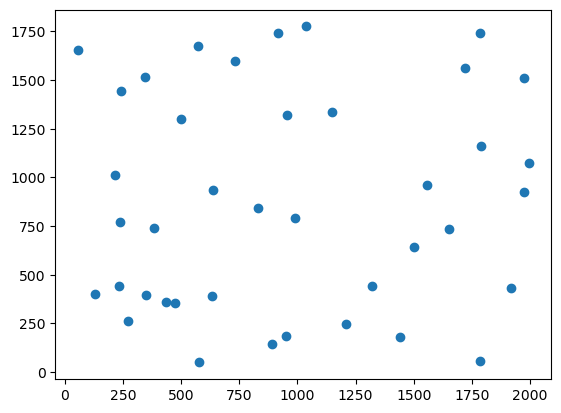

In [4]:
our_random_generator = np.random.RandomState(seed)

customers = 40
x = our_random_generator.randint(0, 2000, size=customers)
y = our_random_generator.randint(0, 2000, size=customers)

customer_orders = our_random_generator.randint(1, 6, size=customers)

plt.scatter(x, y)
plt.show()

Next, we proceed to establish our depot, which serves as the starting point for all deliveries. After careful evaluation, the coordinates (1000, 1000) have proven to be the most suitable for visualization purposes. However, if you wish to experiment or have alternative suggestions, please feel free to propose a different set of coordinates.

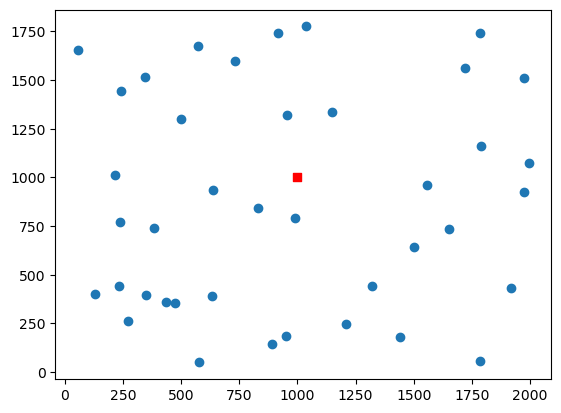

In [5]:
depot = (1000, 1000)
plt.scatter(x, y)
plt.scatter(depot[0], depot[1], color='red', marker=',')
plt.show()

In our simplified example, we will make the assumption that we have an unlimited number of vehicles at our disposal. However, each vehicle has a restricted capacity of 10 containers.

In [6]:
vehicle_cap = 10

And last but certainly not least, we come to the creation of our cost matrix, also referred to as the transport or distance matrix in the business. However, in our specific case, the term "cost matrix" is more appropriate since we are primarily concerned with a single cost parameter.

Now, the question arises: how do we measure the distance in a 2D space? The most reliable method is to utilize the age-old Pythagorean theorem, which states that $c^2 = a^2 + b^2$.

Let's consider an example where we have two points in space: point A with coordinates (2, 2) and point B with coordinates (4, 4). To determine the length of the vector between points A and B, we can imagine it as the hypotenuse of a triangle, with each side representing the difference between the corresponding pairs of x and y coordinates. Thus, the formula for calculating the distance is:
$$ d = \sqrt{(x_B-x_A)^2 + (y_B-y_A)^2} $$

And this is known in the business as <a href="https://en.wikipedia.org/wiki/Euclidean_distance">Euclidian distance</a>.

In [7]:
def cost(locations):
    
    cost_matrix = []
    for i in range(len(locations)):
        row = []
        for j in range(len(locations)):
            xi, yi = locations[i]
            xj, yj = locations[j]
            
            distance = round(math.sqrt((xi-xj)**2 + (yi-yj)**2),3) # Calculate Euclidian distance
            
            row.append(distance)
        cost_matrix.append(row)
    return np.array(cost_matrix)

By applying the aforementioned formula to the example set of coordinates, we obtain the following calculations:

$$ d = \sqrt{(2-4)^2 + (2-4)^2} $$
$$ d = \sqrt{4 + 4} $$
$$ d = \sqrt{8} $$
$$ d = 2.828 $$

Hence, our cost function should generate a matrix with the following values: $$ \begin{pmatrix} 0 & 2.828 \\ 2.828 & 0 \end{pmatrix} $$ Now, let's create a quick test to verify its accuracy.

In [8]:
wanted_matrix = [[0.000, 2.828],
                 [2.828, 0.000]]

return_matrix = cost([(2, 2),(4, 4)])

for i in range(len(wanted_matrix)):
    for j in range(len(wanted_matrix)):
        assert wanted_matrix[i][j] == return_matrix[i][j]

With the assurance that the function works correctly, we can now proceed confidently to create our cost matrix. To achieve this, we need to generate a list of tuples, where each tuple contains the x and y coordinates of a customer, and then append this to a list with the depot coordinates.

In [9]:
customers = [(x[i], y[i]) for i in range(len(x))]
locations = [depot] + customers
cost_matrix = cost(locations)
print(cost_matrix)

[[   0.     670.854  889.454 ...  912.14  1055.959  978.801]
 [ 670.854    0.     345.676 ... 1569.804  420.601 1604.931]
 [ 889.454  345.676    0.    ... 1799.891  219.146 1712.409]
 ...
 [ 912.14  1569.804 1799.891 ...    0.    1967.214  683.734]
 [1055.959  420.601  219.146 ... 1967.214    0.    1919.619]
 [ 978.801 1604.931 1712.409 ...  683.734 1919.619    0.   ]]


## Create initial feasible solution

Alright, we have all needed components to create our solution for CVRP. In first step we will create initial solution by using gready nearest neighbor algorithm. The Greedy Nearest Neighbor algorithm is a simple heuristic algorithm, it starts with an empty set of routes and iteratively adds customers to the routes based on the nearest neighbor criterion until all customers have been visited.

Let's explain how the algorith works in simple steps:

<ol>
    <li> Start with an empty set of routes and select an arbitrary depot as the starting point.</li>
    <li> While there are unvisited customers:</li>
        <ol type="a">
            <li>Choose a route and select the last visited customer of that route as the current customer.</li>
            <li>Find the nearest unvisited customer to the current customer.</li>
            <li>Check if adding the nearest customer to the current route would not exceed the capacity constraint of the    vehicle. If the capacity is not violated, add the customer to the route.</li>
            <li>If the capacity is violated, move to the next route and repeat steps A-C.</li>
        </ol>
    <li>Once all customers have been visited, return the set of routes as a initial solution.</li>
</ol>

In [10]:
def CVRP(orders, cost_matrix, vehicles_cap):
    """
    Greedy Nearest Neighbor algorithm for creating initial solution
    """
    routes = []
    routes_containers = []
    routes_costs = []
    is_visited = [False] * len(orders)
    customers_left = len(orders)

    while customers_left > 0: # Iterate until all customers are visited
        route = []
        route_containers = 0
        current_loc = 0

        route.append(current_loc)

        while customers_left > 0: # Iterate until all customers are visited or the capacity constraint is violated.
            next_stop = None
            current_cost = float('inf')
            
            
            for i in range(len(orders)): # Iterate through all customers 
                if not is_visited[i]:
                    cost = cost_matrix[current_loc][i + 1]
                    if cost < current_cost: # check if current customer cost is lower from current best 
                        next_stop = i
                        current_cost = cost
                        containers_to_add = orders[i]
                        cost_to_add = cost

            if (containers_to_add + route_containers) > vehicles_cap: # Check if the capacity constraint is violated
                break
            
            # Append nearest customer to current route
            route.append(next_stop + 1)
            route_containers += containers_to_add
            current_loc = next_stop
            customers_left -= 1

            try:
                is_visited[next_stop] = True # Mark customer as visited
            except:
                pass

        route.append(0)
        routes.append(route)

    return routes

In [11]:
initial_routes  = CVRP(customer_orders, cost_matrix, vehicle_cap)
print(f"Number of routes: {len(initial_routes)}")
print(f"List of all routes: {initial_routes}")

Number of routes: 13
List of all routes: [[0, 22, 21, 20, 0], [0, 31, 30, 29, 28, 0], [0, 24, 23, 3, 0], [0, 9, 8, 0], [0, 11, 10, 35, 0], [0, 4, 1, 14, 13, 0], [0, 18, 17, 16, 0], [0, 34, 33, 32, 25, 0], [0, 26, 37, 0], [0, 7, 6, 5, 19, 0], [0, 27, 15, 40, 0], [0, 12, 38, 39, 2, 0], [0, 36, 0]]


Alright, we have our routes but we also need to know what exactly our cost is, so let's create a function that calculate route cost and then use it to calculate total cost.

In [12]:
def route_cost(routes):
    """
    Computes single route cost
    """
    cost = 0
    for route in routes:
        for i in range(1,len(route)):
            cost += cost_matrix[route[i]][route[i - 1]]
            
    return cost

total_cost = int(round(route_cost(initial_routes),0))
print(f"Total cost of initial solution: {total_cost}")

Total cost of initial solution: 50099


Alright, now that we have determined the total distance that our fleet needs to cover to deliver all orders, wouldn't it be even better if we could visualize our solution? So, let's proceed by creating a function that takes a list of locations. Each element in the list will be a tuple containing the x and y coordinates of a particular location. Additionally, the function will take a list of routes, a title for the chart, and the total distance covered by all routes.

In [13]:
def plot_solution(locations, routes, name, cost):
    """
    Plot Solution 
    """
    
    x = [locations[i][0] for i in range(1, len(locations))]
    y = [locations[i][1] for i in range(1, len(locations))]
    plt.scatter(x, y)
    plt.scatter(locations[0][0], locations[0][1], color='red', marker=',')

    for route in routes:
        line_x = [locations[i][0] for i in route]
        line_y = [locations[i][1] for i in route]
        plt.plot(line_x, line_y)
        
    plt.title(f"{name}\n Total distance: {round(cost, 3)}")

    plt.show()

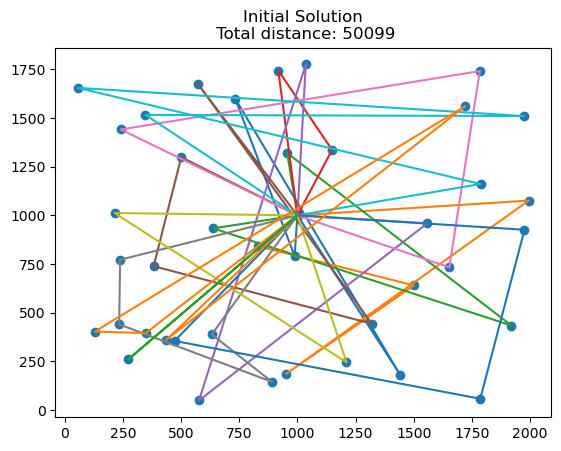

In [14]:
plot_solution(locations, initial_routes, "Initial Solution", total_cost)

And here it is...  With a simple glance, it becomes apparent that many of the routes lack efficiency and fail to adhere to logical patterns. However, it is important to remember that the initial solution is not expected to be perfect. Rather, its purpose is to provide us with a starting point from which we can embark on the journey of optimization.

## Optimization on the initial solution

As we mentioned earlier, metaheuristic techniques are widely favored for final optimization. There are various techniques available, but the one we are going to use is Adaptive Large Neighborhood Search (ALNS). ALNS was proposed by <a href="https://pubsonline.informs.org/doi/abs/10.1287/trsc.1050.0135">Ropke and Pisinger</a> in 2006 for solving many types of Vehicle Routing Problems.

The key idea behind ALNS is to adaptively choose the most promising neighborhood structures and intensify the search in areas where improvement is likely. It achieves this by employing a dynamic search strategy that adjusts the selection probabilities of different neighborhood operators based on their historical performance. This adaptive mechanism allows ALNS to effectively balance exploration and exploitation of the search space, leading to improved solutions.

Here's an overview of how ALNS works:
<ol>
    <li>Initialization: ALNS starts by generating an initial solution.</li>
    <li>Disruption: A disruption phase is performed to introduce diversification and disrupt the current solution. This typically involves applying one or more destructive operations to modify the solution, creating a new disrupted solution.</li>
    <li>Neighborhood exploration: ALNS explores different neighborhoods by applying a set of pre-defined modification and repair operators to the current solution. Modification operators alter the solution by removing or reassigning elements, while repair operators restore the solution to a feasible state.</li>
    <li>Evaluation: After generating a new solution through destroy and repair operations, the objective function or evaluation metric is used to measure its quality. The new solution is compared with the current solution, and it may be accepted or rejected based on certain criteria.</li>
    <li>Adaptive mechanism: ALNS incorporates an adaptive mechanism to dynamically adjust the selection probabilities of destroy and repair operators based on their performance. This allows the algorithm to focus on promising neighborhoods and exploit successful operators more frequently.</li>
    <li>Acceptance criterion: A criterion is employed to determine whether the newly generated solution is accepted as the new current solution. This can be based on factors such as improvement in the objective function value, acceptance probability, or other criteria specific to the problem.</li>
    <li>Iteration and termination: Steps 2-6 are repeated for a predefined number of iterations or until a termination condition is met. This condition can be a maximum number of iterations, a time limit, or reaching a satisfactory solution quality.</li>
</ol>

Let's proceed by importing the ALNS library, which will assist us with the main iterative cycle and a few additional functions. However, we will need to create our custom destruction and repair operators. Additionally, we must modify our initial solution to meet the requirements of the framework. Here are instructions for instalation and more information regarding <a href="https://alns.readthedocs.io/en/latest/setup/installation.html">ALNS Library</a>.

In [15]:
import copy
from types import SimpleNamespace
from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxRuntime

From now on, for the sake of simplicity, we're going to elemenate the starting and ending point in each route. 

In [16]:
initial_solution = [route[1:-1] for route in initial_routes]

Now, we need to make a slight modification to our cost measurement function. We will include the starting and ending points since they are no longer present. As we move forward, we will replace the term "cost" with "objective" to align ourselves with the terminology used in the library.

In [17]:
def route_objective(route):
        """
        Computes single route cost
        """
        route = [0] + route + [0]
        cost = 0
        for i in range(1,len(route)):
            cost += cost_matrix[route[i]][route[i - 1]]
            
        return cost

## Initial State


Now, we'll proceed to create our solution object. This object will consist of two data members: routes and unassigned. The routes attribute will be a list of lists, where each inner list represents a single route, indicating the sequence of customers to be visited. It's important to note that a route does not include the start and end depot. On the other hand, the unassigned attribute will be a list of integers, where each integer represents an unassigned customer.

Additionally, the solution object will include the following methods: Copy - which will return a copy of the current solution; find_route - which will return the route index for a requested customer; and objective_function - which will utilize the previously defined route_objective function to calculate the total route cost.

In [18]:
class InitialState:
    """
    Current solution state. 
    """
    def __init__(self, routes, unassigned=None):
        self.routes = routes
        self.unassigned = unassigned if unassigned is not None else []
    
    def copy(self):
        """
        Returns copy of initial solution
        """
        return InitialState(copy.deepcopy(self.routes))
    
    def find_route(self, customer):
        """
        Return the route that contains the customer.
        """
        for route in self.routes:
            if customer in route:
                return route
    
    def objective(self):
        """
        Computes the total route costs.
        """
        return sum(route_objective(route) for route in self.routes)

## Destroy operator


The destroy operator serves the purpose of randomly removing portions of the initial solution or the current best solution. Additionally, it should identify and eliminate any empty vehicles. Let's begin by creating a function that handles the removal of empty routes.

In [19]:
def remove_empty_routes(state):
    """
    Remove empty routes.
    """
    state.routes = [route for route in state.routes if len(route) != 0]
    return state

Within our solution, we will focus on implementing a single destroy operator. To control the degree of destruction, we will set it to a modest 7%. This allows us to manage the level of damage.The destroy operator function will begin by making a copy of the current best solution. It will then randomly select a certain number of customers and remove them from their respective routes. To further refine the solution, we will utilize the routes remove function, which will eliminate any empty routes and return the broken solution.

In [20]:
degree_of_destruction = 0.07
customers_to_remove = int((len(customers) - 1) * degree_of_destruction)

def random_removal(state, rnd_state):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = state.copy() # get copy of current best solution

    for customer in rnd_state.choice(range(1, 40), customers_to_remove, replace=False): # Iterate through rondomly selected cust
        destroyed.unassigned.append(customer) # add customer to unassigned list
        route = destroyed.find_route(customer) # find customer route
        route.remove(customer) # remove customer from route

    return remove_empty_routes(destroyed)

## Repair Operator


For our repair operator, we will implement a simple greedy algorithm. This algorithm will iterate through all routes and positions, aiming to insert a customer in the best possible position based on the increase in cost criteria.

In [21]:
def greedy_repair(state, rnd_state):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created.
    """
    rnd_state.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop() # remove customer from unassigned list
        route, idx = best_insert(customer, state) # find best place to insert a customer

        if route is not None:
            route.insert(idx, customer) # Add customer to route
        else:
            state.routes.append([customer]) # Create a new route if the customer cannot be inserted in an existing one

    return state


def best_insert(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    """
    best_cost, best_route, best_idx = None, None, None
    
    for route in state.routes:
        for idx in range(len(route) + 1):
            
            # Check if customer order can fit
            if can_insert(customer, route): 
                cost = insert_cost(customer, route, idx) # Get insertion cost
                
                # check if cost is less than best know cost
                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


def can_insert(customer, route):
    """
    Checks if inserting customer does not exceed vehicle capacity.
    """
    total = 0
    for i in range(len(route)):
        total += customer_orders[customer - 1]
        
    return total <= vehicle_cap # Return true if new total orders <= vehicle capacity


def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at requested index.
    New distance as (First Customer to New Customer) + (New Customer to Customer After)
    Old distance as (First Customer to Customer After)
    return New Distance minus Old distance
    """
    predcesor = 0 if idx == 0 else route[idx - 1] # The customer before
    succcesor = 0 if idx == len(route) else route[idx] # The customer after
    
    
    return cost_matrix[predcesor][customer] + cost_matrix[customer][succcesor] - cost_matrix[predcesor][succcesor]

## Inital solution optimisation 

Now that we have all the necessary building blocks in place, we can proceed to create our ALNS instance and incorporate our operators.

In [22]:
# create alns instance
alns = ALNS(np.random.RandomState(seed))

# add destroy and repair operators
alns.add_destroy_operator(random_removal)
alns.add_repair_operator(greedy_repair)

# create initial solution object from initial routes
init = InitialState(initial_solution)

Now it is time to set selction, acception and stop critiria. They all are provided from the framework but no harm in explaining them. For Operator selection critiria we will use the Roulette Weel function. The function keep track on operator preformance. In each iteration, a destroy and a repair operator are selected based on the current weights. The selected operators are applied to the current solution, resulting in a new candidate solution. This candidate is evaluated which leads to one of four outcomes:
<ol>
    <li>The candidate solution is a new global best.</li>
    <li>The candidate solution is better than the current solution, but not a new global best.</li>
    <li>The candidate solution is accepted.</li>
    <li>The candidate solution is rejected.</li>
</ol>

For each of the four outcomes reward is given and the weights for selected operators are recalculated as:

$$ 
\begin{align}
    \omega_d &= \theta \omega_d + (1 - \theta) s_j, \\
    \omega_r &= \theta \omega_r + (1 - \theta) s_j,
\end{align} 
$$

Were $ \theta $ is decay parameter and $ \theta \in [0, 1] $

In [23]:
rewards = [25, 5, 1, 0] # Reward points for respective outcomes 1 - 4
decay = 0.8 # decay coefficient
destroy_operators = 1 
repair_operators = 1

select = RouletteWheel(rewards, decay, destroy_operators, repair_operators)

Acceptance criteria is used to accept or reject the candidate solution. In our case we will use Record-To-Record travel. The function is accepting a solution when the absolute gap betwenn the candidate and current is less than the treshold. The treshold $ T $ is updated in each iteration by step $`\gamma$:
$$ T \gets \max \{ T_\text{end},~T - \gamma \} $$

for reference:
    
Santini, A., Ropke, S. & Hvattum, L.M. A comparison of acceptance criteria for the adaptive large neighbourhood search metaheuristic. Journal of Heuristics (2018) 24 (5): 783–815.

In [24]:
initial_cost = init.objective()
start_gap = 0.02
end_gap = 0
max_iterations = 9000

accept = RecordToRecordTravel.autofit(initial_cost, start_gap, end_gap, max_iterations)

As our stoping criteria we will use MaxRuntime functions, this function takes the duration in seconds as an input and stops the algorithm once the specified time has elapsed.

In [25]:
stop = MaxRuntime(5)

<strong>And, here we are... Let's the magic happen!</strong>

In [26]:
result = alns.iterate(init, select, accept, stop)
solution = result.best_state

Alright, let's see what we have after 5 seconds of hard work. 

In [27]:
objective = int(round(solution.objective(),0))
print(f"Number of routes: {len(solution.routes)}")
print(f"Optimised Solution cost is: {objective}.")

Number of routes: 9
Optimised Solution cost is: 20653.


Well, not bad... We've made significant progress by reducing the number of vehicles utilised and achieving a cost reduction of more than half. 

Let's go ahead and actually observe our optimised solution.

Number of routes: 9


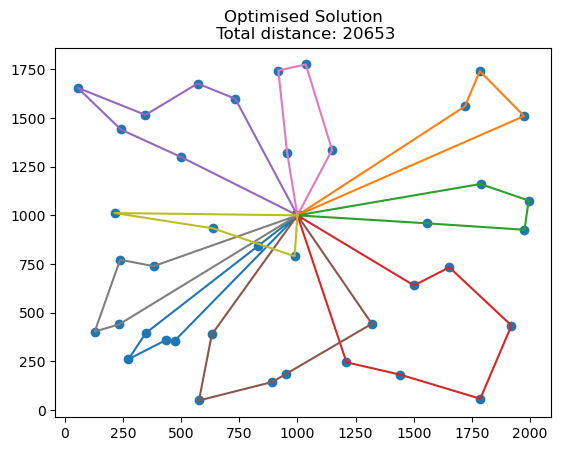

In [28]:
routes = [[0] + route + [0] for route in solution.routes]
print(f"Number of routes: {len(routes)}")
plot_solution(locations, routes, "Optimised Solution", objective)

Wow... clearly much better than our initial mess. 

One of the extars that ANLS library have is a statistic module, the stat module keep track on overal preformance of the algorithm. Let's go ahead and plot our costs on each iteration.

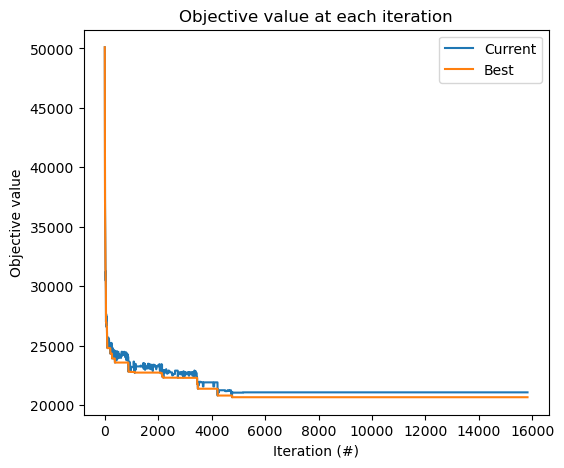

In [29]:
_, ax = plt.subplots(figsize=(6, 5))
result.plot_objectives(ax=ax)

We can see that it took us a litle over 4000 iteration to find our best know solution.

## Conclusions


We have transitioned from mere points in a 2D space to a well-structured and efficient delivery plan, representing the complexity of real-life scenarios. This transformation demonstrates the power of metaheuristic techniques, as they enable us to efficiently solve NP-hard problems in a relatively short amount of time.